### **Capstone Project: SkimLit**

In [1]:
# DL needs
import tensorflow as tf
import keras as kr

# Data needs
import pandas as pd
from sklearn.model_selection import train_test_split

# Numerical computation needs
import numpy as np

# plotting needs
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# ensuring reproducibility
random_seed=42
tf.random.set_seed(random_seed)

import sys
sys.path.append('/home/rudraksha14/Desktop/RAY_RISE_ABOVE_YOURSELF/Programming/tensorflow/')

import important_functionalities as impf

2025-04-11 17:19:27.383725: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
baseline_results = {'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1_score': 0.6989250353450294}

In [3]:
data_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

# check all of the filenames in the target directory
import os 
filenames = [data_dir + filename for filename in os.listdir(data_dir)]

In [4]:
def get_lines(filename):
    '''
    Reads file given a filename (text) and returns the lines of text as a list.
    '''
    with open(filename,'r') as file:
        return file.readlines()

In [5]:
def preprocess_text_with_line_number(filename):
    '''
    Takes in filename (str), reads its content and sorts through each line.
    Extracts things like the target label, the text of the sentence, how many sentences are in the current abstract and what sentence number the target line is.
    Returns a list of dictationaries of abstract line data.
    '''

    input_lines = get_lines(filename) # get all lines from file name
    abstract_lines = '' # create an empty abstract 
    abstract_samples = [] # create an empty list of abstracts

    # loop through each line in the target file
    for line in input_lines:
        if line.startswith('###'): # check to see if line is an ID line
            abstract_id = line
            abstract_lines = "" # reset the abstract string for every new abstract
            
        elif line.isspace(): # check to see if line is a newline
            abstract_lines_split = abstract_lines.splitlines() # split abstract into separate lines ('\n')

            # this is one particular abstract we are dealing with
            # iterate through each line in a single abstract, and count them at the same time.
            for abstract_line_no,abstract_line in enumerate(abstract_lines_split):
                line_data = {} # create an empty dictationary for each line
                target_text_split = abstract_line.split("\t")
                # text before \t is label, and after \t is text

                line_data['target'] = target_text_split[0] # get target label
                line_data['text'] = target_text_split[1].lower() # get target text and lowercase it
                line_data['line_number'] = abstract_line_no # what number line does the line appear in the abstract?
                line_data["total_lines"] = len(abstract_lines_split) - 1 # how many total lines are there in the target abstract ? (start from 0)
                
                # add line data to abstract samples list
                abstract_samples.append(line_data)

        else: # if the above conditions are not fulfilled, the line contains a labelled sentence
            abstract_lines += line
    
    return abstract_samples

In [6]:
%%time
# get data from file and pre-process it

train_samples = preprocess_text_with_line_number(data_dir+'train.txt')
val_samples = preprocess_text_with_line_number(data_dir+'dev.txt')
test_samples = preprocess_text_with_line_number(data_dir+'test.txt')
len(train_samples),len(val_samples),len(test_samples)

CPU times: user 317 ms, sys: 89.8 ms, total: 407 ms
Wall time: 404 ms


(180040, 30212, 30135)

In [7]:
# # turning data into dataframe to further visualize
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [8]:
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()
len(train_sentences),len(val_sentences),len(test_sentences)

(180040, 30212, 30135)

In [9]:
# NUMERIC_LABELLING
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df['target'].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [10]:
# ONE_HOT_ENCODING
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse_output=False) # we want non-sparse matrix

train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1,1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [11]:
# Get the class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
print(class_names,num_classes)

['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS'] 5


**4. Preparing data for deep sequence models**

In [12]:
# how long is each sentence on an average?
sen_len = [len(sen.split()) for sen in train_sentences]
avg_sentence_len = tf.reduce_mean(sen_len)
print(avg_sentence_len)

tf.Tensor(26, shape=(), dtype=int32)


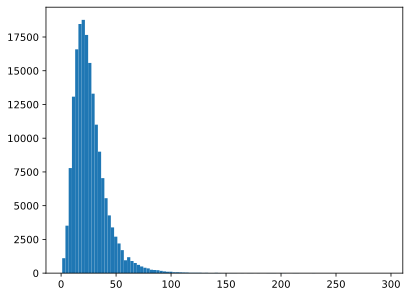

In [13]:
# what's the distribution look like?
plt.hist(sen_len,bins = 100);


In [14]:
# how long of a sentence length covers 95% of all sentences
output_seq_len = int(np.percentile(sen_len,95))
print(output_seq_len)

55


In [15]:
# what's the max length of sentence
tf.reduce_max(sen_len)

<tf.Tensor: shape=(), dtype=int32, numpy=296>

In [16]:
# Vocabulary size (refer paper: for PUBMED-20k it is 68k)
MAX_TOKENS  = 68000

In [17]:
# creating the text-vectorizer layer
text_vectorizer = tf.keras.layers.TextVectorization(max_tokens = MAX_TOKENS, # no of words in vocab
                                                    output_sequence_length = output_seq_len, # desired output length of vectorized sequences
                                                    # all other params kept default,
                                                    name = 'text_vectorizer'
                                                    )

In [18]:
# adapt the text vectorizer to train sentences
text_vectorizer.adapt(train_sentences)

In [19]:
# test out text-vectorizer on some random sentences
import random

target_sentence = random.choice(train_sentences)
print(f'Text:\n{target_sentence}')
print(f'\nLength of text: {len(target_sentence.split())}')
print(f'\nVectorized text: {text_vectorizer([target_sentence])} ')

Text:
patients with p-p@s@k negative tumors derived significant benefit from tamoxifen ( hr @ , p < @ ) , while patients whose tumor did express p-p@s@k did not ( hr = @ , p = @ ) , p for interaction @ .

Length of text: 43

Vectorized text: [[   12     7 18130   469  1563  1919    37   398    27  3394   273    14
    258    12  1989   724   112  7531 18130   112    31   273    14    14
     11   605     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]] 


In [20]:
# how many words in training vocabulary, and most and least common words
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in vocab:{len(rct_20k_text_vocab)}')
print(f'Most common words in vocab:{rct_20k_text_vocab[:5]}')
print(f'Least common words in vocab:{rct_20k_text_vocab[-5:]}')

Number of words in vocab:64841
Most common words in vocab:['', '[UNK]', 'the', 'and', 'of']
Least common words in vocab:['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [21]:
# get the config of text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorizer',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

In [22]:
# creating a custom embedding layer
embedding_layer = tf.keras.layers.Embedding(input_dim = len(rct_20k_text_vocab), # length of vocabulary
                                            output_dim = 128,
                                            mask_zero = True, # use masking to handle variable sequence length (saves space)
                                            name="token_embedding"
                                            )

# larger the embedding, more params the model has to train,
# smaller the embedding, the embedding may not capture more information as larger embedding

In [24]:
# show an example embedding
target_sentence = random.choice(train_sentences)
print(f'Text:\n{target_sentence}')
print(f'\nVectorized text: {text_vectorizer([target_sentence])} ')
print(f'\nEmbedded text: {embedding_layer(text_vectorizer([target_sentence]))} ')
print(f'Shape of embedded text:{embedding_layer(text_vectorizer([target_sentence])).shape}')

Text:
magnesium supplementation resulted in a lower incidence of newborn hyperbilirubinemia ( @ % vs. @ % , p = @ ) and newborn hospitalization ( @ % vs. @ % , p = @ ) .

Vectorized text: [[2492  464  568    5    8  105  214    4 3973 9408   44   14    3 3973
   843   44   14    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]] 

Embedded text: [[[-0.01134396  0.04616233 -0.02382579 ...  0.04696729  0.04696805
   -0.01475575]
  [ 0.02850062  0.02639096  0.02933521 ...  0.04775306 -0.00056343
    0.03676051]
  [-0.02900071 -0.0492583  -0.04275426 ... -0.02418685  0.03318964
    0.03470231]
  ...
  [ 0.04475489  0.00765265 -0.01312243 ...  0.00072521 -0.01993202
    0.01424668]
  [ 0.04475489  0.00765265 -0.01312243 ...  0.00072521 -0.01993202
    0.01424668]
  [ 0.04475489  0.00765265 -0.01312243 ...  0.00072521 -0.01993202
    0.01424668]]] 
Sha

In [25]:
# creating datasets using tf.data API

### Turn our data into tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))

### Take the Tensor slice datasets and turn them into prefetched datasets
BATCH_SIZE = 32
train_dataset = train_dataset.batch(batch_size = BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(batch_size = BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size = BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

**5. Model 1: Conv1D with custom token embeddings**

In [27]:
inputs = tf.keras.layers.Input(shape = (1,),dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs to integers
token_embeddings = embedding_layer(text_vectors) # create embedding
x = tf.keras.layers.Conv1D(filters = 128,
                           kernel_size = 5,
                           padding = 'same',
                           activation = 'relu'
                           )(token_embeddings)
x = tf.keras.layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector from conv layers
outputs = tf.keras.layers.Dense(units = num_classes,activation = 'softmax')(x)


# create the model
model_1 = tf.keras.models.Model(inputs = inputs, outputs=outputs)
model_1.summary()

/home/rudraksha14/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorizer                 │ (None, 55)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_embedding (Embedding)     │ (None, 55, 128)        │     8,299,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 55, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,382,341 (31.98 MB)

 Trainable params: 8,382,341 (31.98 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# compile the model
model_1.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])

In [30]:
# fitting the model
model_1.fit(train_dataset,
            steps_per_epoch = int(0.1*len(train_dataset)),
            epochs = 3,
            validation_data = valid_dataset,
            validation_steps = int(0.1*len(valid_dataset))
            )

Epoch 1/3


/home/rudraksha14/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


562/562 ━━━━━━━━━━━━━━━━━━━━ 54s 94ms/step - accuracy: 0.5290 - loss: 1.1315 - val_accuracy: 0.7453 - val_loss: 0.6777
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 51s 91ms/step - accuracy: 0.7513 - loss: 0.6717 - val_accuracy: 0.7733 - val_loss: 0.6251
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 48s 86ms/step - accuracy: 0.7750 - loss: 0.6145 - val_accuracy: 0.7879 - val_loss: 0.5919


In [31]:
# evaluate model 1
model_1.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7893 - loss: 0.5896


[0.5911982655525208, 0.7885939478874207]

In [33]:
# make predictions using model 1
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs,model_1_pred_probs.shape

945/945 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


(array([[4.8021951e-01, 1.1484997e-01, 8.3722331e-02, 2.9175681e-01,
         2.9451495e-02],
        [4.2478094e-01, 2.6819614e-01, 1.0243167e-02, 2.8724262e-01,
         9.5371231e-03],
        [1.1600729e-01, 3.9192247e-03, 1.3784262e-03, 8.7867886e-01,
         1.6211026e-05],
        ...,
        [1.2809483e-05, 8.8317774e-04, 1.1136319e-03, 7.4800605e-06,
         9.9798286e-01],
        [3.7690848e-02, 4.3724737e-01, 9.1664448e-02, 4.7869828e-02,
         3.8552755e-01],
        [1.3585223e-01, 7.6505250e-01, 3.8941670e-02, 2.7861003e-02,
         3.2292526e-02]], dtype=float32),
 (30212, 5))

In [35]:
# convert pred-probs to classes

pred_labels = tf.argmax(model_1_pred_probs,axis=1)
pred_classes  = [class_names[label] for label in pred_labels]
pred_labels,pred_classes

(<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>,
 ['BACKGROUND',
  'BACKGROUND',
  'OBJECTIVE',
  'METHODS',
  'RESULTS',
  'METHODS',
  'RESULTS',
  'METHODS',
  'RESULTS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'OBJECTIVE',
  'METHODS',
  'METHODS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'RESULTS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'BACKGROUND',
  'OBJECTIVE',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'OBJECTIVE',
  'METHODS',
  'METHODS',
  'CONCLUSIONS',
  'BACKGROUND',
  'RESULTS',
  'CONCLUSIONS',
  'BACKGROUND',
  'BACKGROUND',
  'CONCLUSIONS',
  'METHODS',
  'METHODS',
  'METHODS',
  'RESULTS',
  'RESULTS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'RESULTS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'METHODS',
  'METHODS',
  'RESULTS',
  'CONCLUSIONS',
  'METHODS',
  'RESULTS',
  'RESULTS',
  'RESULTS',
  'RESULTS',
  'RESULTS',
  'RESULTS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'BACKGROUND',
  'OBJECTIVE',
  'METHODS'

In [37]:
model_1_results = impf.calculate_results(val_labels_encoded,pred_labels)
model_1_results

{'accuracy': 78.85939361842976,
 'precision': 0.7857351875581878,
 'recall': 0.7885939361842976,
 'f1_score': 0.7863604692957813}

***-- CONTD IN NEXT NOTEBOOK --***